# Test Trained Model on ONE video: ED/ES Dice, Segmenting 32 frame clips consecutively

In [1]:
model_names = ["Original-Pretrained-R2plus1DMotionSegNet_model.pth", "dropout-0_10-R2plus1DMotionSegNet_model.pth", "dropout-0_25-R2plus1DMotionSegNet_model.pth", "dropout-0_50-R2plus1DMotionSegNet_model.pth", "dropout-0_75-R2plus1DMotionSegNet_model.pth"]

In [2]:
import os
os.chdir("..")

In [3]:
os.getcwd()

'/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking'

In [4]:
%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset
from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet

# v1 dropout, not in place dropout
from src.model.dropout_0_10_R2plus1D_18_MotionNet import dropout_0_10_R2plus1D_18_MotionNet
from src.model.dropout_0_25_R2plus1D_18_MotionNet import dropout_0_25_R2plus1D_18_MotionNet
from src.model.dropout_0_50_R2plus1D_18_MotionNet import dropout_0_50_R2plus1D_18_MotionNet
from src.model.dropout_0_75_R2plus1D_18_MotionNet import dropout_0_75_R2plus1D_18_MotionNet

# v2 dropout (in place before motion heads)
from src.model.dropout_v2_0_10_R2plus1D_18_MotionNet import dropout_v2_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_25_R2plus1D_18_MotionNet import dropout_v2_0_25_R2plus1D_18_MotionNet



# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

In [5]:
batch_size = 4
num_workers = max(4, cpu_count()//2)

def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

In [6]:
with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", raise_for_es_ed=False, subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)

100%|██████████| 16/16 [00:01<00:00, 13.88it/s]


In [7]:
len(test_dataset)

1276

In [8]:
def divide_to_consecutive_clips(video, clip_length=32, interpolate_last=False):
    source_video = video.copy()
    video_length = video.shape[1]
    left = video_length % clip_length
    if left != 0 and interpolate_last:
        source_video = torch.Tensor(source_video).unsqueeze(0)
        source_video = F.interpolate(source_video, size=(int(np.round(video_length / clip_length) * clip_length), 112, 112),
                                     mode="trilinear", align_corners=False)
        source_video = source_video.squeeze(0).squeeze(0)
        source_video = source_video.numpy()
    
    videos = np.empty(shape=(1, 3, clip_length, 112, 112))

    for start in range(0, int(clip_length * np.round(video_length / clip_length)), clip_length):
        one_clip = source_video[:, start: start + clip_length]
        one_clip = np.expand_dims(one_clip, 0)
        videos = np.concatenate([videos, one_clip])
    return videos[1:]


def get_all_possible_start_points(ed_index, es_index, video_length, clip_length):
    assert es_index - ed_index > 0, "not a ED to ES clip pair"
    possible_shift = clip_length - (es_index - ed_index)
    allowed_right = video_length - es_index
    if allowed_right < possible_shift:
        return np.arange(ed_index - possible_shift + 1, video_length - clip_length + 1)
    if possible_shift < 0:
        return np.array([ed_index])
    elif ed_index < possible_shift:
        return np.arange(ed_index + 1)
    else:
        return np.arange(ed_index - possible_shift + 1, ed_index + 1)

## Load in Models

In [9]:
# hold tuples of (name, model object)
loaded_in_models = []

In [10]:
for model_name in model_names:
    model_save_path = f"save_models/{model_name}"
    if model_name == "Original-Pretrained-R2plus1DMotionSegNet_model.pth":
        model = torch.nn.DataParallel(R2plus1D_18_MotionNet())
    else:
        model = torch.nn.DataParallel(WIP_R2plus1D_18_MotionNet())
    
    model.to("cuda")
    torch.cuda.empty_cache()
    model.load_state_dict(torch.load(model_save_path)["model"])
    print(f'{model_name} has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')
    model.eval();
    
    loaded_in_models.append((model_name, model))

print(len(loaded_in_models))

Original-Pretrained-R2plus1DMotionSegNet_model.pth has 31575731 parameters.
dropout-0_10-R2plus1DMotionSegNet_model.pth has 31575731 parameters.
dropout-0_25-R2plus1DMotionSegNet_model.pth has 31575731 parameters.
dropout-0_50-R2plus1DMotionSegNet_model.pth has 31575731 parameters.
dropout-0_75-R2plus1DMotionSegNet_model.pth has 31575731 parameters.
5


## Pick a specific (or random) video to do inference via our Models

In [11]:
# currently getting a random test sample for inference, we can adjust to always look at a specific example to compare between multiple models more than 2 or for future viewing
# test_pat_index = np.random.randint(len(test_dataset))
test_pat_index = 2

video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]

### Get all possible 32-Frame Clips that covers ED-ES

In [12]:
possible_starts = get_all_possible_start_points(ed_index, es_index, video.shape[1], clip_length=32)
possible_starts

array([153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163])

In [13]:
print(len(possible_starts))

11


### Segment All 32-Frame Clips for all Models

In [14]:
# segment using all models
all_segmentation_outputs = []
all_motion_outputs = []

# for each model, segment the clips
for name, model in loaded_in_models:
    
    segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))
    motion_outputs = np.empty(shape=(1, 4, 32, 112, 112))
    for start in possible_starts:
        one_clip = np.expand_dims(video[:, start: start + 32], 0)
        segmentation_output, motion_output = model(torch.Tensor(one_clip))
        segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
        motion_outputs = np.concatenate([motion_outputs, motion_output.cpu().detach().numpy()])
    segmentation_outputs = segmentation_outputs[1:]
    motion_outputs = motion_outputs[1:]
    
    # save 
    all_segmentation_outputs.append(segmentation_outputs)
    all_motion_outputs.append(motion_outputs)

# reshape them to be used later
for i in range(len(all_segmentation_outputs)):
    all_segmentation_outputs[i] = np.argmax(all_segmentation_outputs[i], axis=1)

for i in range(len(all_motion_outputs)):
    all_motion_outputs[i] = np.argmax(all_motion_outputs[i], axis=1)

In [15]:
# segmentation shapes
print("segmentation shapes:")
for name, segmentations in zip(model_names, all_segmentation_outputs):
    print(f'{name} segmentation shape: {segmentations.shape}')
print("\nmotion shapes:")
for name, motions in zip(model_names, all_motion_outputs):
    print(f'{name} segmentation shape: {motions.shape}')

    
# segmentations_1 = np.argmax(segmentation_outputs_1, axis=1)
# print(f'model 1 segmentation shape: {segmentations_1.shape}')

# segmentations_2 = np.argmax(segmentation_outputs_2, axis=1)
# print(f'model 2 segmentation shape: {segmentations_1.shape}')

# print()
# # motion output shapes? 
# motion_1 = np.argmax(motion_outputs_1, axis=1)
# print(f'model 1 motion shape: {motion_1.shape}')

# motion_2 = np.argmax(motion_outputs_2, axis=1)
# print(f'model 2 motion shapes: {motion_2.shape}')

segmentation shapes:
Original-Pretrained-R2plus1DMotionSegNet_model.pth segmentation shape: (11, 32, 112, 112)
dropout-0_10-R2plus1DMotionSegNet_model.pth segmentation shape: (11, 32, 112, 112)
dropout-0_25-R2plus1DMotionSegNet_model.pth segmentation shape: (11, 32, 112, 112)
dropout-0_50-R2plus1DMotionSegNet_model.pth segmentation shape: (11, 32, 112, 112)
dropout-0_75-R2plus1DMotionSegNet_model.pth segmentation shape: (11, 32, 112, 112)

motion shapes:
Original-Pretrained-R2plus1DMotionSegNet_model.pth segmentation shape: (11, 32, 112, 112)
dropout-0_10-R2plus1DMotionSegNet_model.pth segmentation shape: (11, 32, 112, 112)
dropout-0_25-R2plus1DMotionSegNet_model.pth segmentation shape: (11, 32, 112, 112)
dropout-0_50-R2plus1DMotionSegNet_model.pth segmentation shape: (11, 32, 112, 112)
dropout-0_75-R2plus1DMotionSegNet_model.pth segmentation shape: (11, 32, 112, 112)


### Plot the Segmented LV Sizes (in pixels) with Scatter plots
Start symbols mark the beginning of the 32-Frame video clips.

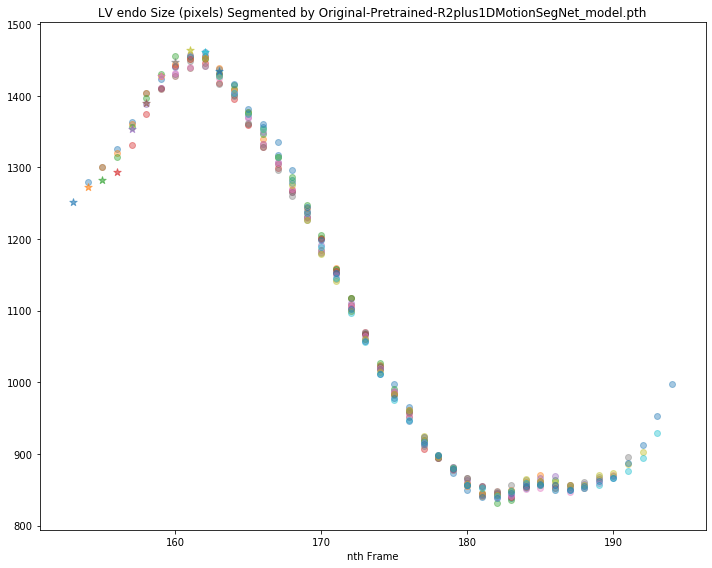

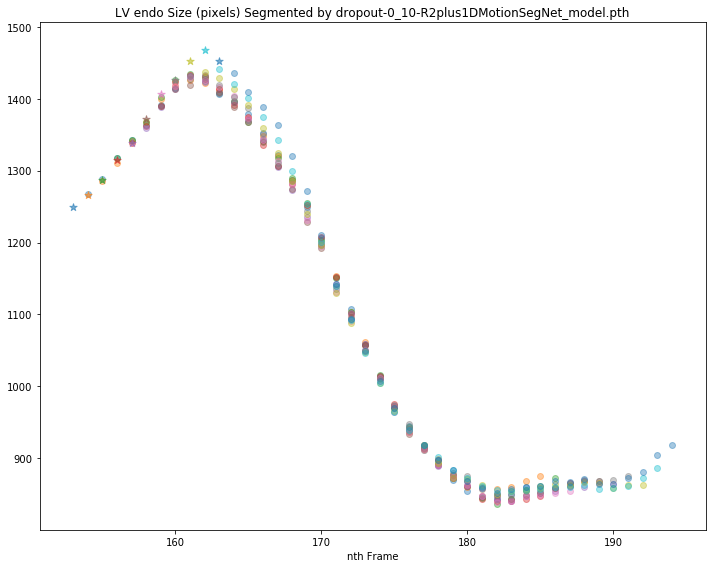

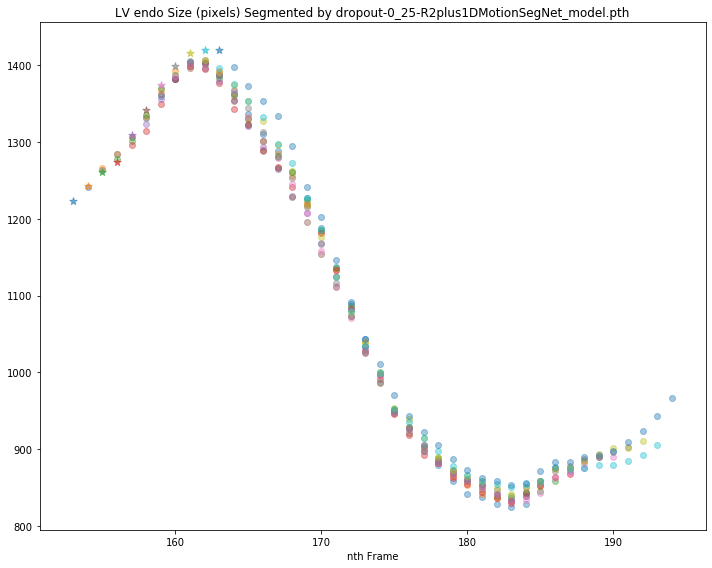

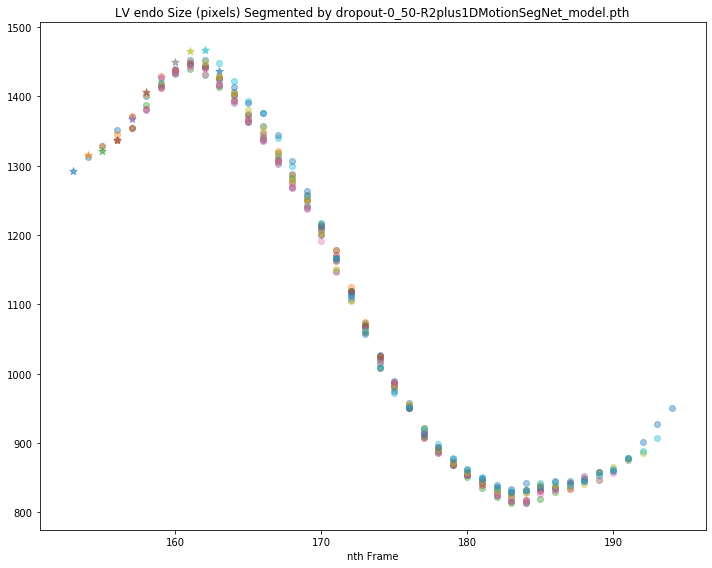

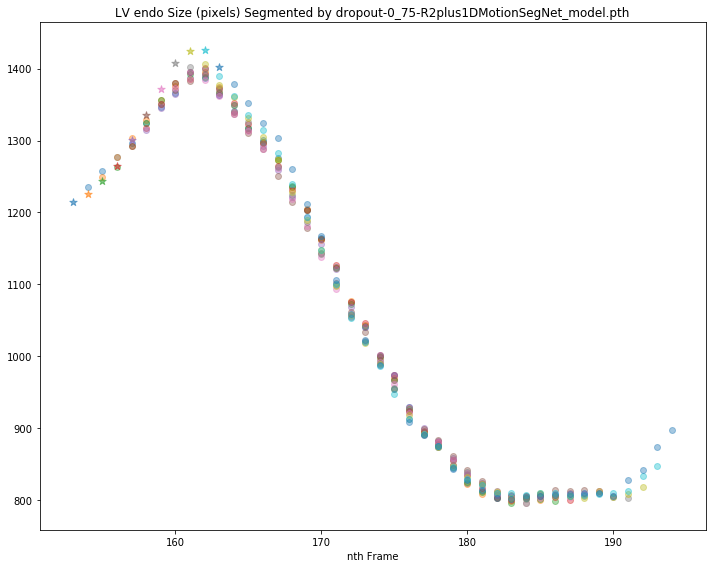

In [16]:
############ this works #########

# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 8))

# for i in range(len(possible_starts)):
#     lv_sizes = np.sum(all_segmentation_outputs[0][i], axis=(1, 2))
#     scatter = ax1.scatter(np.arange(possible_starts[i] + 1, possible_starts[i] + 32), lv_sizes[1:], alpha=0.4)
#     color = scatter.get_facecolors()[0]
#     ax1.scatter(possible_starts[i], lv_sizes[0], color=color, alpha=0.6, s=60, marker="*")

# for i in range(len(possible_starts)):
#     lv_sizes = np.sum(all_segmentation_outputs[1][i], axis=(1, 2))
#     scatter = ax2.scatter(np.arange(possible_starts[i] + 1, possible_starts[i] + 32), lv_sizes[1:], alpha=0.4)
#     color = scatter.get_facecolors()[0]
#     ax2.scatter(possible_starts[i], lv_sizes[0], color=color, alpha=0.6, s=60, marker="*")  


# ax1.set_title(f"LV endo Size (pixels) Segmented by {model_names[0]}")
# ax1.set_xlabel("nth Frame")

# ax2.set_title(f"LV endo Size (pixels) Segmented by {model_names[1]}")
# ax2.set_xlabel("nth Frame")

# # plt.tight_layout()
# plt.show()

#######################

# plot all of them
for i in range(len(loaded_in_models)):
    plt.figure(figsize=(10,8))
    for j in range(len(possible_starts)):
        lv_sizes = np.sum(all_segmentation_outputs[i][j], axis=(1, 2))
        scatter = plt.scatter(np.arange(possible_starts[j] + 1, possible_starts[j] + 32), lv_sizes[1:], alpha=0.4)
        color = scatter.get_facecolors()[0]
        plt.scatter(possible_starts[j], lv_sizes[0], color=color, alpha=0.6, s=60, marker="*")
        
    plt.title(f"LV endo Size (pixels) Segmented by {model_names[i]}")
    plt.xlabel("nth Frame")
    plt.tight_layout()
    plt.show()

# Full batch of possible random clips
# LV endo sizes cloud

### Plot the Segmented LV Sizes (in pixels) with line plots
Start symbols mark the beginning of the 32-Frame video clips.

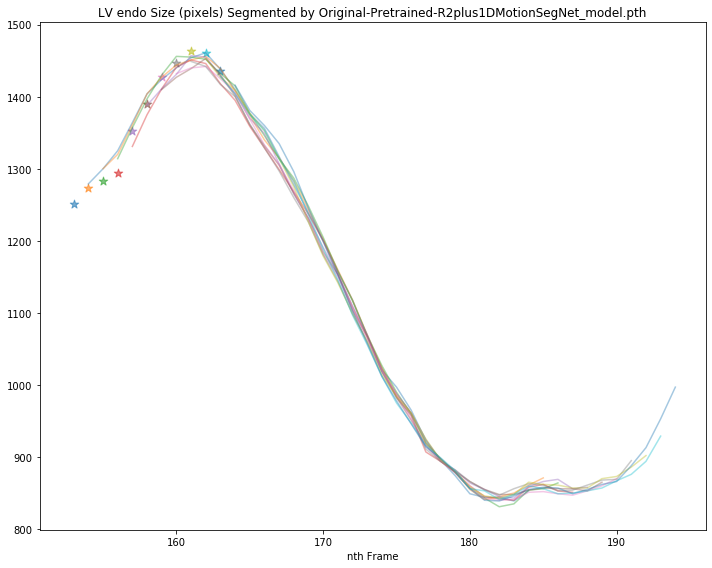

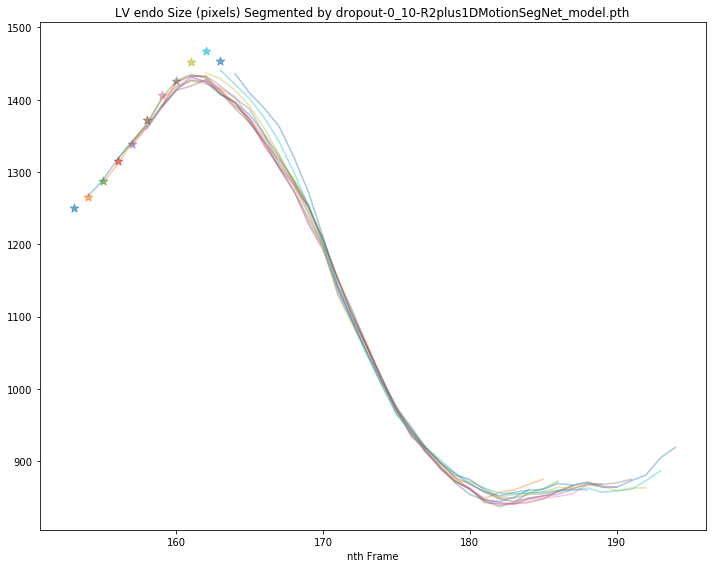

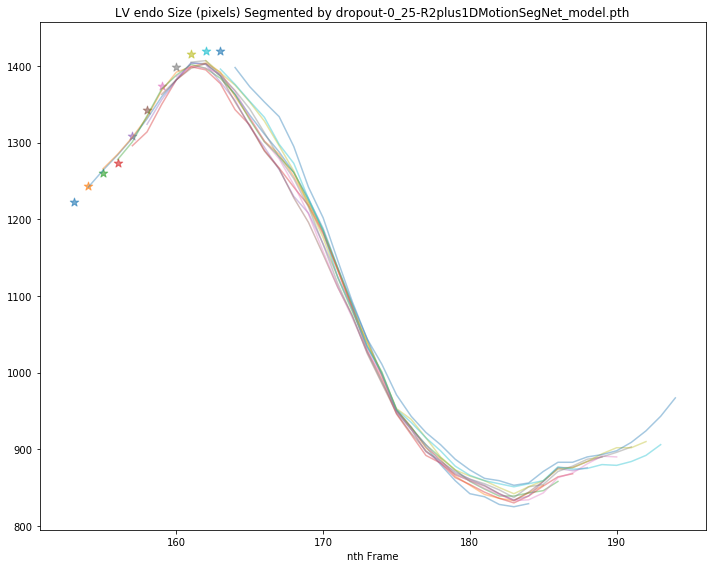

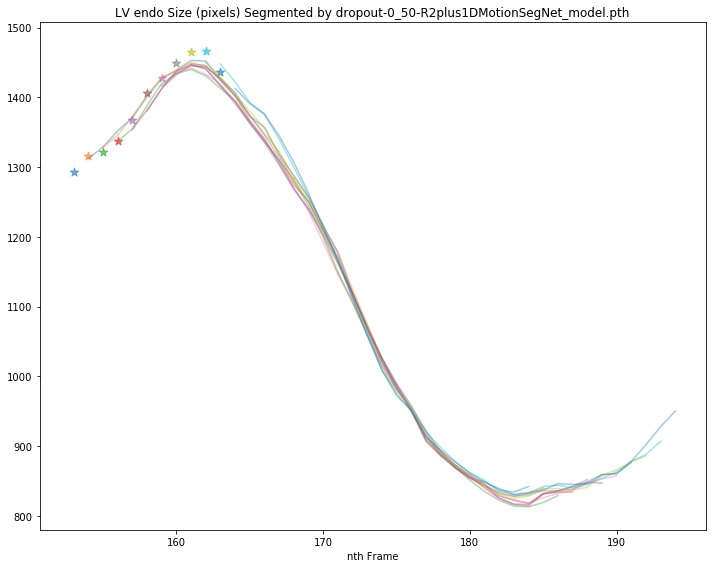

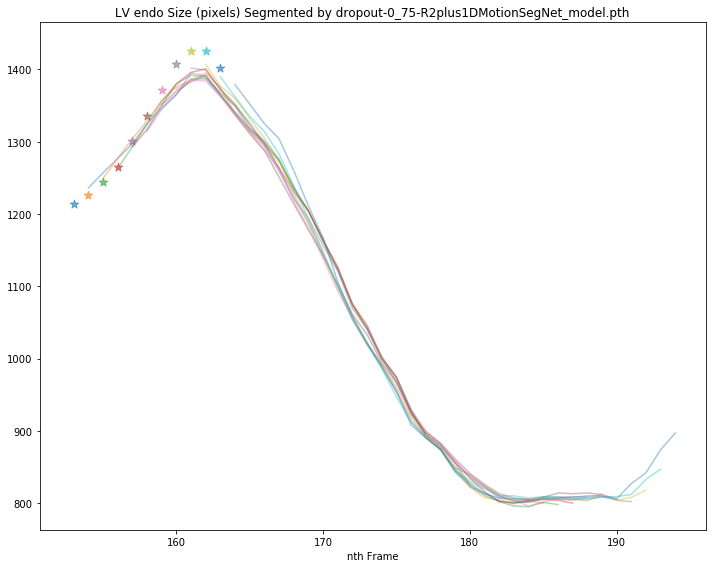

In [17]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
# for i in range(len(possible_starts)):
#     lv_sizes = np.sum(segmentations_1[i], axis=(1, 2))
#     scatter = ax1.plot(np.arange(possible_starts[i] + 1, possible_starts[i] + 32), lv_sizes[1:], alpha=0.4)
#     color = scatter[0].get_color()
#     ax1.scatter(possible_starts[i], lv_sizes[0], color=color, alpha=0.6, s=80, marker="*")

# for i in range(len(possible_starts)):
#     lv_sizes = np.sum(segmentations_2[i], axis=(1, 2))
#     scatter = ax2.plot(np.arange(possible_starts[i] + 1, possible_starts[i] + 32), lv_sizes[1:], alpha=0.4)
#     color = scatter[0].get_color()
#     ax2.scatter(possible_starts[i], lv_sizes[0], color=color, alpha=0.6, s=80, marker="*")

# ax1.set_title(f"LV endo Size (pixels) Segmented by {model_name_1}")
# ax1.set_xlabel("nth Frame")

# ax2.set_title(f"LV endo Size (pixels) Segmented by {model_name_2}")
# ax2.set_xlabel("nth Frame")

# # plt.legend(loc="lower right", fontsize=14, ncol=2)
# plt.tight_layout()
# plt.show()


#####################
for i in range(len(loaded_in_models)):
    plt.figure(figsize=(10, 8))
    for j in range(len(possible_starts)):
        lv_sizes = np.sum(all_segmentation_outputs[i][j], axis=(1, 2))
        scatter = plt.plot(np.arange(possible_starts[j] + 1, possible_starts[j] + 32), lv_sizes[1:], alpha=0.4)
        color = scatter[0].get_color()
        plt.scatter(possible_starts[j], lv_sizes[0], color=color, alpha=0.6, s=80, marker="*")
    
    plt.title(f"LV endo Size (pixels) Segmented by {model_names[i]}")
    plt.xlabel("nth Frame")
    plt.tight_layout()
    plt.show()


# Full batch of possible random clips
# LV endo sizes cloud

### Divide a Test Patient's Echo videos into consecutive 32-Frame clips

In [18]:
video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]

interpolate_last = True

consecutive_clips = divide_to_consecutive_clips(video, interpolate_last=interpolate_last)
consecutive_clips.shape

(7, 3, 32, 112, 112)

### Segment the Consecutive 32-Frame video clips
If the video length is not a multiple of 32 (32-frame video clips), then interpolate the video so its length equals to the nearest multiple of 32.

For example, a video with length 88 will be interpolated to 96, and a video with length 72 will be interpolated to 64.

In [19]:
# # MODEL 1
# segmentation_outputs_1 = np.empty(shape=(1, 2, 32, 112, 112))
# motion_outputs_1 = np.empty(shape=(1, 4, 32, 112, 112))

# for i in range(consecutive_clips.shape[0]):
#     one_clip = np.expand_dims(consecutive_clips[i], 0)
#     segmentation_output, motion_output = model_1(torch.Tensor(one_clip))
#     segmentation_outputs_1 = np.concatenate([segmentation_outputs_1, segmentation_output.cpu().detach().numpy()])
#     motion_outputs_1 = np.concatenate([motion_outputs_1, motion_output.cpu().detach().numpy()])
# segmentation_outputs_1 = segmentation_outputs_1[1:]
# motion_outputs_1 = motion_outputs_1[1:]

# # MODEL 2
# segmentation_outputs_2 = np.empty(shape=(1, 2, 32, 112, 112))
# motion_outputs_2 = np.empty(shape=(1, 4, 32, 112, 112))

# for i in range(consecutive_clips.shape[0]):
#     one_clip = np.expand_dims(consecutive_clips[i], 0)
#     segmentation_output, motion_output = model_2(torch.Tensor(one_clip))
#     segmentation_outputs_2 = np.concatenate([segmentation_outputs_2, segmentation_output.cpu().detach().numpy()])
#     motion_outputs_2 = np.concatenate([motion_outputs_2, motion_output.cpu().detach().numpy()])
# segmentation_outputs_2 = segmentation_outputs_2[1:]
# motion_outputs_2 = motion_outputs_2[1:]

all_consecutive_32_frame_clips_segmentation_outputs = []
all_consecutive_32_frame_clips_motion_outputs = []

for i in range(len(loaded_in_models)):
    segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))
    motion_outputs = np.empty(shape=(1, 4, 32, 112, 112))
    
    for j in range(consecutive_clips.shape[0]):
        one_clip = np.expand_dims(consecutive_clips[i], 0)
        segmentation_output, motion_output = loaded_in_models[i][1](torch.Tensor(one_clip))
        segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
        motion_outputs = np.concatenate([motion_outputs, motion_output.cpu().detach().numpy()])
    
    segmentation_outputs = segmentation_outputs[1:]
    motion_outputs = motion_outputs[1:]
    
    all_consecutive_32_frame_clips_segmentation_outputs.append(segmentation_outputs)
    all_consecutive_32_frame_clips_motion_outputs.append(motion_outputs)

In [20]:
# reshape all outputs
for i in range(len(all_consecutive_32_frame_clips_segmentation_outputs)):
    all_consecutive_32_frame_clips_segmentation_outputs[i] = np.argmax(all_consecutive_32_frame_clips_segmentation_outputs[i], axis=1)

for seg in all_consecutive_32_frame_clips_segmentation_outputs:
    print(seg.shape)

# shapes should be (8, 32, 112, 112)
    
# segmentations_1 = np.argmax(segmentation_outputs_1, axis=1)
# segmentations_1.shape

# segmentations_2 = np.argmax(segmentation_outputs_2, axis=1)
# segmentations_2.shape

(7, 32, 112, 112)
(7, 32, 112, 112)
(7, 32, 112, 112)
(7, 32, 112, 112)
(7, 32, 112, 112)


### If the video length is not a multiple of 32 and has been interpolated during segmentation
then interpolate the lv sizes results back to the original length of the input video

In [21]:
## This looks like exactly the same code that's been repeated in cells above. But whatever, I'll trust that Yida wrote this for a reason?

######## model 1
# segmentation_outputs_1 = np.empty(shape=(1, 2, 32, 112, 112))
# motion_outputs_1 = np.empty(shape=(1, 4, 32, 112, 112))

# for i in range(consecutive_clips.shape[0]):
#     one_clip = np.expand_dims(consecutive_clips[i], 0)
#     segmentation_output, motion_output = model_1(torch.Tensor(one_clip)) # make sure u use the right model
#     segmentation_outputs_1 = np.concatenate([segmentation_outputs_1, segmentation_output.cpu().detach().numpy()])
#     motion_outputs_1 = np.concatenate([motion_outputs_1, motion_output.cpu().detach().numpy()])
# segmentation_outputs_1 = segmentation_outputs_1[1:]
# motion_outputs_1 = motion_outputs_1[1:]

# segmentations_1 = np.argmax(segmentation_outputs_1, axis=1)
# print(f'{model_name_1} segmentations:', segmentations_1.shape)

# # TODO: Yida didn't do np.argmax on the motion output, maybe we can do something about that later.


# ###### model 2
# segmentation_outputs_2 = np.empty(shape=(1, 2, 32, 112, 112))
# motion_outputs_2 = np.empty(shape=(1, 4, 32, 112, 112))

# for i in range(consecutive_clips.shape[0]):
#     one_clip = np.expand_dims(consecutive_clips[i], 0)
#     segmentation_output, motion_output = model_2(torch.Tensor(one_clip)) # make sure u use the right model
#     segmentation_outputs_2 = np.concatenate([segmentation_outputs_2, segmentation_output.cpu().detach().numpy()])
#     motion_outputs_2 = np.concatenate([motion_outputs_2, motion_output.cpu().detach().numpy()])
# segmentation_outputs_2 = segmentation_outputs_2[1:]
# motion_outputs_2 = motion_outputs_2[1:]

# segmentations_2 = np.argmax(segmentation_outputs_2, axis=1)
# print(f'{model_name_2} segmentations:', segmentations_2.shape)

# TODO: Yida didn't do np.argmax on the motion output, maybe we can do something about that later.
#####################################
### I will run this code segment bc i have weird outputs below (p=0.1 and 0.5 are giving very wrong EFs)

all_consecutive_32_frame_clips_segmentation_outputs = []
all_consecutive_32_frame_clips_motion_outputs = []

for i in range(len(loaded_in_models)):
    segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))
    motion_outputs = np.empty(shape=(1, 4, 32, 112, 112))
    
    for j in range(consecutive_clips.shape[0]):
        one_clip = np.expand_dims(consecutive_clips[i], 0)
        segmentation_output, motion_output = loaded_in_models[i][1](torch.Tensor(one_clip)) 
        segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
        motion_outputs = np.concatenate([motion_outputs, motion_output.cpu().detach().numpy()])
    segmentation_outputs = segmentation_outputs[1:]
    motion_outputs = motion_outputs[1:]
    
    segmentation_outputs = np.argmax(segmentation_outputs, axis=1)
    motion_outputs = np.argmax(motion_outputs, axis=1)

    all_consecutive_32_frame_clips_segmentation_outputs.append(segmentation_outputs)
    all_consecutive_32_frame_clips_motion_outputs.append(motion_outputs)

In [22]:
############# model 1
# segmentations_1 = segmentations_1.reshape(-1, 112, 112)
# segmentations_1 = torch.Tensor(segmentations_1).unsqueeze(0).unsqueeze(0)
# segmentations_1 = F.interpolate(segmentations_1, size=(video.shape[1], 112, 112), 
#                                            mode="trilinear", align_corners=False)
# segmentations_1 = segmentations_1.squeeze(0).squeeze(0).numpy()

# print('seg 1', segmentations_1.shape)

# ############# model 2

# segmentations_2 = segmentations_2.reshape(-1, 112, 112)
# segmentations_2 = torch.Tensor(segmentations_2).unsqueeze(0).unsqueeze(0)
# segmentations_2 = F.interpolate(segmentations_2, size=(video.shape[1], 112, 112), 
#                                            mode="trilinear", align_corners=False)
# segmentations_2 = segmentations_2.squeeze(0).squeeze(0).numpy()

# print('seg 2', segmentations_2.shape)

for i in range(len(all_consecutive_32_frame_clips_segmentation_outputs)):
    tmp = all_consecutive_32_frame_clips_segmentation_outputs[i]
    
    tmp = tmp.reshape(-1, 112, 112)
    tmp = torch.Tensor(tmp).unsqueeze(0).unsqueeze(0)
    tmp = F.interpolate(tmp, size= (video.shape[1], 112, 112), 
                                           mode="trilinear", align_corners=False)
    tmp = tmp.squeeze(0).squeeze(0).numpy()
    
    all_consecutive_32_frame_clips_segmentation_outputs[i] = tmp
    
    print(all_consecutive_32_frame_clips_segmentation_outputs[i].shape)
    
# shapes should be (248, 112, 112)

(217, 112, 112)
(217, 112, 112)
(217, 112, 112)
(217, 112, 112)
(217, 112, 112)


### Plot the Segmented LV Sizes from the Consecutive Clips

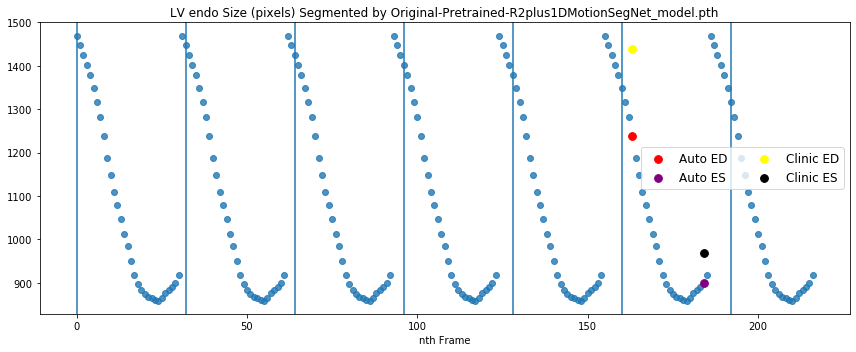

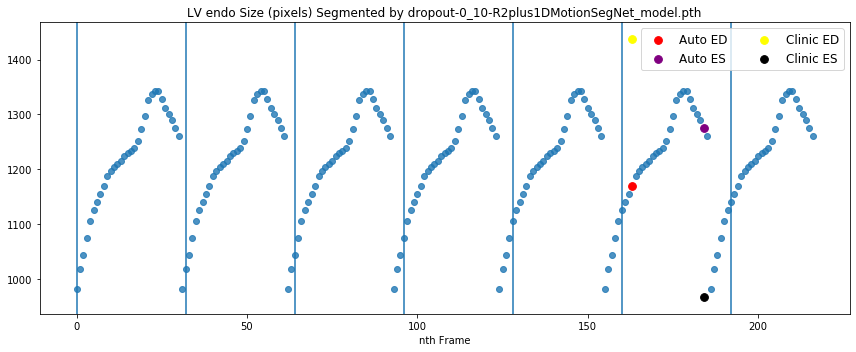

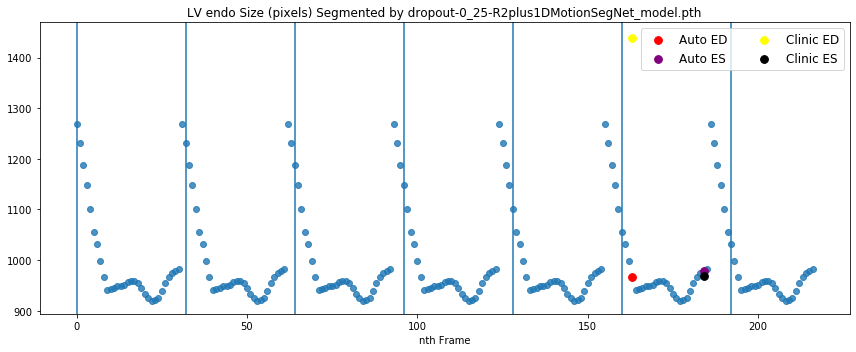

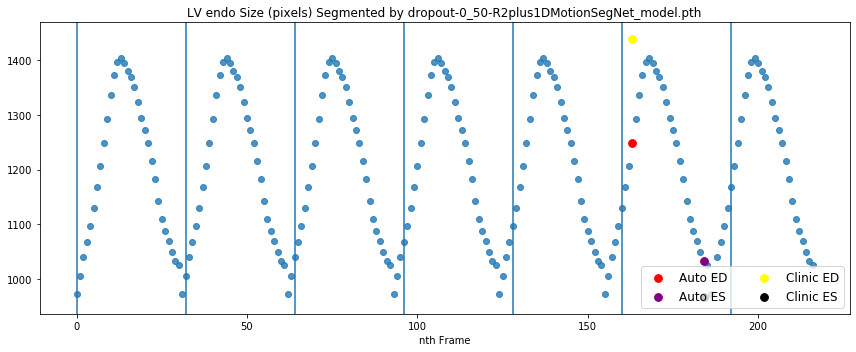

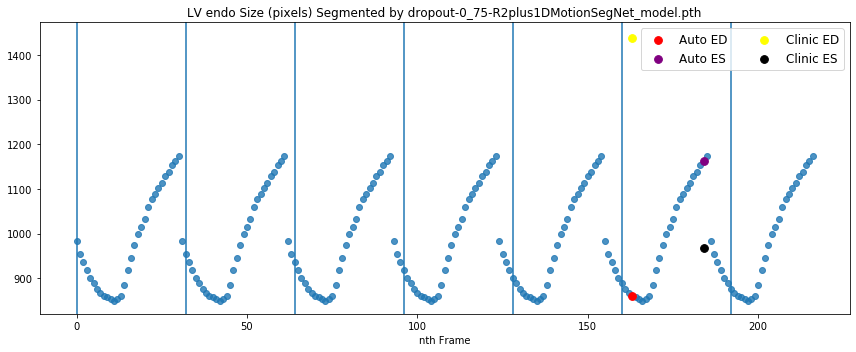

In [23]:
# ############# model 1
# fig, ax = plt.subplots(1, figsize=(12, 5))

# lv_sizes = np.sum(segmentations_1, axis=(1, 2)).ravel()

# # if interpolate_last:
# #     lv_sizes = lv_sizes.tolist()[:-32]
# #     lv_sizes += interped_last_clip.tolist()

# ax.scatter(np.arange(len(lv_sizes)), lv_sizes, alpha=0.8)

# ax.scatter(ed_index, lv_sizes[ed_index],
#             color="red", s=60, label="Auto ED")

# ax.scatter(es_index, lv_sizes[es_index],
#             color="purple", s=60, label="Auto ES")

# ax.set_title(f"LV endo Size (pixels) Segmented by {model_name_1}")
# ax.set_xlabel("nth Frame")

# plt.scatter(ed_index, np.sum(ed_label), 
#             s=60, color="yellow", label="Clinic ED")
# plt.scatter(es_index, np.sum(es_label), 
#             s=60, color="black", label="Clinic ES")
# # bottom, top = plt.ylim()
# # plt.ylim(bottom=200, top=top+200)

# for i in range(0, len(lv_sizes), 32):
#     ax.axvline(i, 0, 1)

# plt.legend(fontsize=12, ncol=2)
# plt.tight_layout()
# plt.show()

# #################### model 2
# fig, ax = plt.subplots(1, figsize=(12, 5))

# lv_sizes = np.sum(segmentations_2, axis=(1, 2)).ravel()

# # if interpolate_last:
# #     lv_sizes = lv_sizes.tolist()[:-32]
# #     lv_sizes += interped_last_clip.tolist()

# ax.scatter(np.arange(len(lv_sizes)), lv_sizes, alpha=0.8)

# ax.scatter(ed_index, lv_sizes[ed_index],
#             color="red", s=60, label="Auto ED")

# ax.scatter(es_index, lv_sizes[es_index],
#             color="purple", s=60, label="Auto ES")

# ax.set_title(f"LV endo Size (pixels) Segmented by {model_name_2}")
# ax.set_xlabel("nth Frame")

# plt.scatter(ed_index, np.sum(ed_label), 
#             s=60, color="yellow", label="Clinic ED")
# plt.scatter(es_index, np.sum(es_label), 
#             s=60, color="black", label="Clinic ES")
# # bottom, top = plt.ylim()
# # plt.ylim(bottom=200, top=top+200)

# for i in range(0, len(lv_sizes), 32):
#     ax.axvline(i, 0, 1)

# plt.legend(fontsize=12, ncol=2)
# plt.tight_layout()
# plt.show()


for i in range(len(loaded_in_models)):
    plt.figure(figsize=(12,5))
    
    lv_sizes = np.sum(all_consecutive_32_frame_clips_segmentation_outputs[i], axis=(1, 2)).ravel()
    # if interpolate_last:
    #     lv_sizes = lv_sizes.tolist()[:-32]
    #     lv_sizes += interped_last_clip.tolist()
    
    plt.scatter(np.arange(len(lv_sizes)), lv_sizes, alpha=0.8)

    plt.scatter(ed_index, lv_sizes[ed_index],
                color="red", s=60, label="Auto ED")

    plt.scatter(es_index, lv_sizes[es_index],
                color="purple", s=60, label="Auto ES")

    plt.title(f"LV endo Size (pixels) Segmented by {loaded_in_models[i][0]}")
    plt.xlabel("nth Frame")

    plt.scatter(ed_index, np.sum(ed_label), 
                s=60, color="yellow", label="Clinic ED")
    plt.scatter(es_index, np.sum(es_label), 
                s=60, color="black", label="Clinic ES")
    
    # bottom, top = plt.ylim()
    # plt.ylim(bottom=200, top=top+200)

    for i in range(0, len(lv_sizes), 32):
        plt.axvline(i, 0, 1)

    plt.legend(fontsize=12, ncol=2)
    plt.tight_layout()
    plt.show()

In [24]:
all_one_array_segmentations = []


for i in range(len(loaded_in_models)):
    segmentations = all_consecutive_32_frame_clips_segmentation_outputs[i]
    one_array_segmentations = segmentations.reshape(-1, 112, 112)
    all_one_array_segmentations.append(one_array_segmentations)
    
    print(f"-------- {loaded_in_models[i][0]} --------")
    print("ED LV Dice: {:.3f}".format(categorical_dice(one_array_segmentations[ed_index], ed_label, 1)))
    print("ES LV Dice: {:.3f}".format(categorical_dice(one_array_segmentations[es_index], es_label, 1)))

# print()
# print("-------- Model 2 --------")
# one_array_segmentations_2 = segmentations_2.reshape(-1, 112, 112)
# print("ED LV Dice: {:.3f}".format(categorical_dice(one_array_segmentations_2[ed_index], ed_label, 1)))
# print("ES LV Dice: {:.3f}".format(categorical_dice(one_array_segmentations_2[es_index], es_label, 1)))

-------- Original-Pretrained-R2plus1DMotionSegNet_model.pth --------
ED LV Dice: 0.895
ES LV Dice: 0.925
-------- dropout-0_10-R2plus1DMotionSegNet_model.pth --------
ED LV Dice: 0.895
ES LV Dice: 0.813
-------- dropout-0_25-R2plus1DMotionSegNet_model.pth --------
ED LV Dice: 0.770
ES LV Dice: 0.817
-------- dropout-0_50-R2plus1DMotionSegNet_model.pth --------
ED LV Dice: 0.798
ES LV Dice: 0.932
-------- dropout-0_75-R2plus1DMotionSegNet_model.pth --------
ED LV Dice: 0.746
ES LV Dice: 0.876


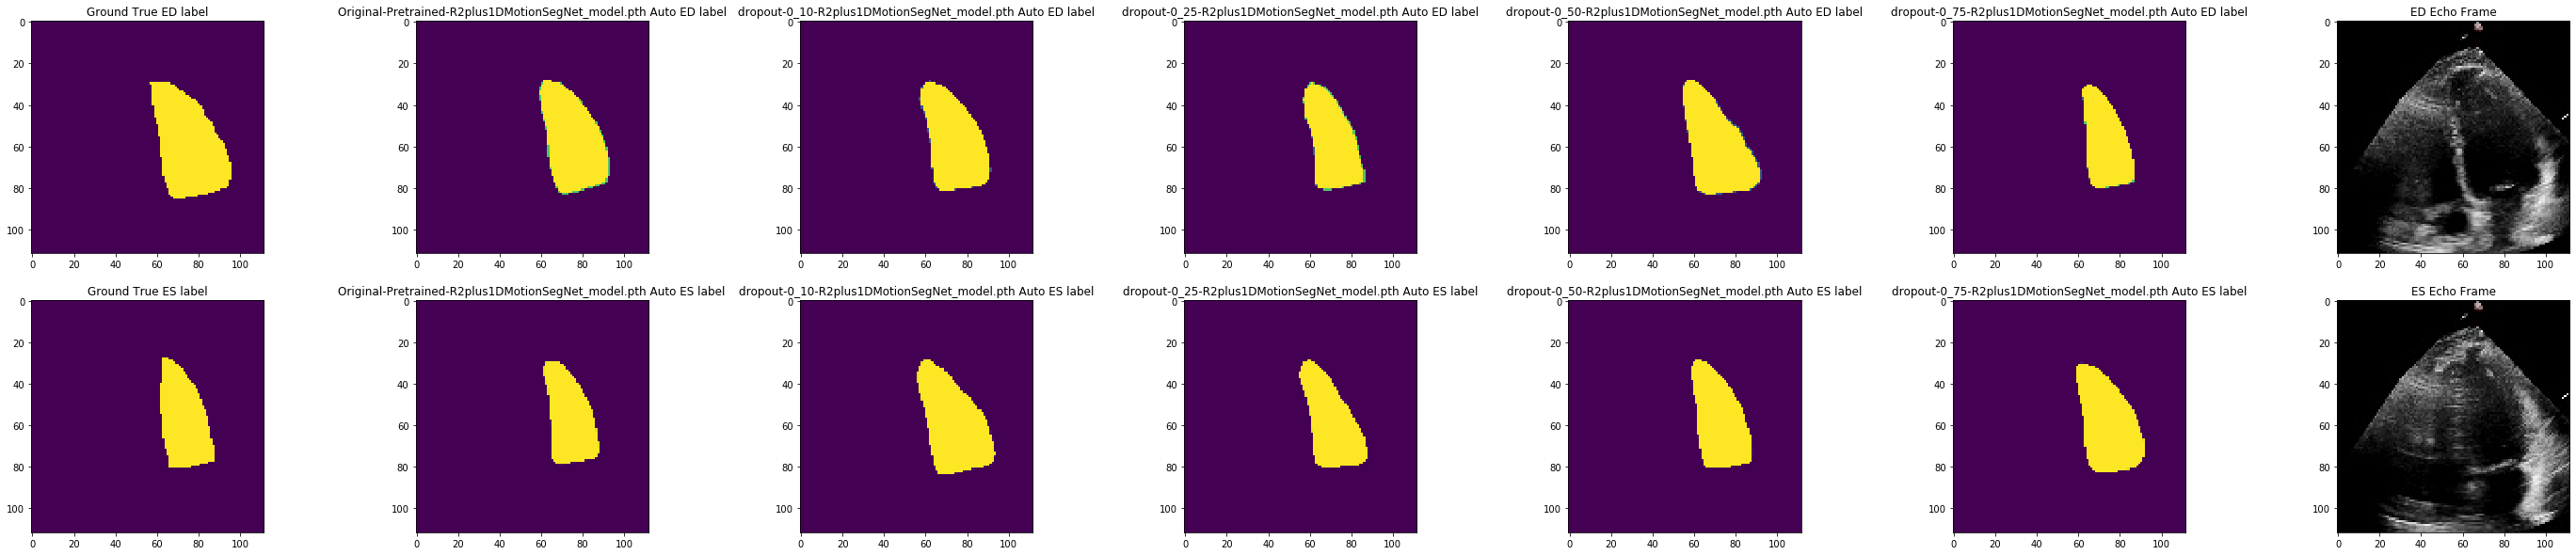

In [25]:
fig, ax = plt.subplots(2, 2 + len(loaded_in_models), figsize=(50, 10))

ax[0][0].set_title("Ground True ED label")
ax[0][0].imshow(ed_label)

ax[1][0].set_title("Ground True ES label")
ax[1][0].imshow(es_label)

ax[0][len(loaded_in_models)+1].set_title("ED Echo Frame")
ax[0][len(loaded_in_models)+1].imshow(ed_frame.transpose([1, 2, 0]))

ax[1][len(loaded_in_models)+1].set_title("ES Echo Frame")
ax[1][len(loaded_in_models)+1].imshow(es_frame.transpose([1, 2, 0]))

ind = 1
for i in range(len(loaded_in_models)):
    ax[0][ind].set_title(f"{loaded_in_models[i][0]} Auto ED label")
    ax[0][ind].imshow(all_one_array_segmentations[i][ed_index])
    ax[1][ind].set_title(f"{loaded_in_models[i][0]} Auto ES label")
    ax[1][ind].imshow(all_one_array_segmentations[i][es_index])
    ind+=1


# ax[0][2].set_title("WIP Model Auto ED label")
# ax[0][2].imshow(one_array_segmentations_2[ed_index])




# ax[1][2].set_title("WIP Model Auto ES label")
# ax[1][2].imshow(one_array_segmentations_2[es_index])



# plt.tight_layout(pad=25.0)
plt.show()

### Compute the Ejection Fraction

In [26]:
# from queue import SimpleQueue as squeue

def EDESpairs(diastole, systole):
    dframes = np.sort(np.array(diastole))
    sframes = np.sort(np.array(systole))
    clips = []
    
    inds = np.searchsorted(dframes, sframes, side='left')
    for i, sf in enumerate(sframes):
        if inds[i] == 0: # no prior diastolic frames for this sf
            continue
        best_df = diastole[inds[i]-1] # diastole frame nearest this sf.
        if len(clips) == 0 or best_df != clips[-1][0]:
            clips.append((best_df, sf))
            
    return clips

In [27]:
def get_clip_pairs(segmentations):
    size = np.sum(segmentations, axis=(1, 2)).ravel()
    _05cut, _85cut, _95cut = np.percentile(size, [5, 85, 95]) 

    trim_min = _05cut
    trim_max = _95cut
    trim_range = trim_max - trim_min
    systole = find_peaks(-size, distance=20, prominence=(0.50 * trim_range))[0]
    diastole = find_peaks(size, distance=20, prominence=(0.50 * trim_range))[0]

    # keep only real diastoles..
    diastole = [x for x in diastole if size[x] >= _85cut]
    # Add first frame
    if np.mean(size[:3]) >= _85cut:
        diastole = [0] + diastole
    diastole = np.array(diastole)

    clip_pairs = EDESpairs(diastole, systole)
    return clip_pairs

In [28]:
all_clip_pairs = []
for seg in all_consecutive_32_frame_clips_segmentation_outputs:
    all_clip_pairs.append(get_clip_pairs(seg))


# clip_pairs_1 = get_clip_pairs(segmentations_1)
# clip_pairs_2 = get_clip_pairs(segmentations_2)

In [29]:
for clip in all_clip_pairs:
    print(clip)

[(0, 24), (31, 55), (62, 86), (93, 117), (124, 148), (155, 179)]
[(24, 31), (55, 62), (86, 93), (117, 124), (148, 155), (179, 186)]
[(0, 22), (31, 53), (62, 84), (93, 115), (124, 146), (155, 177)]
[(13, 31), (44, 62), (75, 93), (106, 124), (137, 155), (168, 186)]
[(30, 42), (61, 73), (92, 104), (123, 135), (154, 166), (185, 197)]


In [30]:
def get_predicted_efs(segmentations, clip_pairs):
    one_array_of_segmentations = segmentations.reshape(-1, 112, 112)

    predicted_efs = []

    for i in range(len(clip_pairs)):
        output_ED = one_array_of_segmentations[clip_pairs[i][0]]
        output_ES = one_array_of_segmentations[clip_pairs[i][1]]

        length_ed, radius_ed = get2dPucks((output_ED == 1).astype('int'), (1.0, 1.0))
        length_es, radius_es = get2dPucks((output_ES == 1).astype('int'), (1.0, 1.0))

        edv = np.sum(((np.pi * radius_ed * radius_ed) * length_ed / len(radius_ed)))
        esv = np.sum(((np.pi * radius_es * radius_es) * length_es / len(radius_es)))

        ef_predicted = (edv - esv) / edv * 100

        predicted_efs.append(ef_predicted)

    return predicted_efs

In [31]:
all_predicted_efs = []
for seg, clip in zip(all_consecutive_32_frame_clips_segmentation_outputs, all_clip_pairs):
    all_predicted_efs.append(get_predicted_efs(seg, clip))

for i in range(len(loaded_in_models)):
    print(f"{loaded_in_models[i][0]}: {all_predicted_efs[i]}")

# predicted_efs_1 = get_predicted_efs(segmentations_1, clip_pairs_1)
# predicted_efs_2 = get_predicted_efs(segmentations_2, clip_pairs_2)
# print('model1:', predicted_efs_1)
# print('model2:', predicted_efs_2)

Original-Pretrained-R2plus1DMotionSegNet_model.pth: [60.625315428647, 60.625315428647, 60.625315428647, 60.625315428647, 60.625315428647, 60.625315428647]
dropout-0_10-R2plus1DMotionSegNet_model.pth: [39.33495413637681, 39.33495413637681, 39.33495413637681, 39.33495413637681, 39.33495413637681, 39.33495413637681]
dropout-0_25-R2plus1DMotionSegNet_model.pth: [39.34747751457721, 39.34747751457721, 39.34747751457721, 39.34747751457721, 39.34747751457721, 39.34747751457721]
dropout-0_50-R2plus1DMotionSegNet_model.pth: [46.70778695116217, 46.70778695116217, 46.70778695116217, 46.70778695116217, 46.70778695116217, 46.70778695116217]
dropout-0_75-R2plus1DMotionSegNet_model.pth: [43.951874320899535, 43.951874320899535, 43.951874320899535, 43.951874320899535, 43.951874320899535, 43.951874320899535]


In [32]:
# Use the ground true lables to derive the EF
output_ED = ed_label
output_ES = es_label

# Use the Simpson's Monoplane method
length_ed, radius_ed = get2dPucks((output_ED == 1).astype('int'), (1.0, 1.0))
length_es, radius_es = get2dPucks((output_ES == 1).astype('int'), (1.0, 1.0))

edv = np.sum(((np.pi * radius_ed * radius_ed) * length_ed / len(radius_ed)))
esv = np.sum(((np.pi * radius_es * radius_es) * length_es / len(radius_es)))

ef_predicted = (edv - esv) / edv * 100

In [33]:
for i in range(len(loaded_in_models)):
    print(f"{loaded_in_models[i][0]} Avg Derived EF: {np.mean(all_predicted_efs[i]):.2f}")
# print("WIP Avg Derived EF: {:10.2f}".format(np.mean(predicted_efs_2)))

print("True EF: {:56.2f}".format(EF)) 
print("Trace EF: {:55.2f} (EF Derived from Clinician's ED & ES labels using Simpson's monoplane method)".format(ef_predicted))

Original-Pretrained-R2plus1DMotionSegNet_model.pth Avg Derived EF: 60.63
dropout-0_10-R2plus1DMotionSegNet_model.pth Avg Derived EF: 39.33
dropout-0_25-R2plus1DMotionSegNet_model.pth Avg Derived EF: 39.35
dropout-0_50-R2plus1DMotionSegNet_model.pth Avg Derived EF: 46.71
dropout-0_75-R2plus1DMotionSegNet_model.pth Avg Derived EF: 43.95
True EF:                                                    50.79
Trace EF:                                                   50.44 (EF Derived from Clinician's ED & ES labels using Simpson's monoplane method)
